To run this example locally, [install Ploomber](https://ploomber.readthedocs.io/en/latest/get-started/install.html) and execute: `ploomber examples -n templates/mlflow`

To start a free, hosted JupyterLab: [![binder-logo](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Ftemplates/mlflow%252FREADME.ipynb%26branch%3Dmaster)

Found an issue? [Let us know.](https://github.com/ploomber/projects/issues/new?title=templates/mlflow%20issue)

Have questions? [Ask us anything on Slack.](https://ploomber.io/community/)


# Ploomber + MLflow

*Note: This is an advanced tutorial and assumes familiarity with basic Ploomber concepts, you may want to read the basic tutorial first and then come back here.*

*Note: This example requires ploomber 0.13.2 or higher.*

<!-- start description -->
Train a grid of models and log them to MLflow.
<!-- end description -->

## Introduction

Let's first load our `pipeline.yaml` as a DAG object and plot it:

In [1]:
from ploomber.spec import DAGSpec

  0%|          | 0/13 [00:00<?, ?it/s]

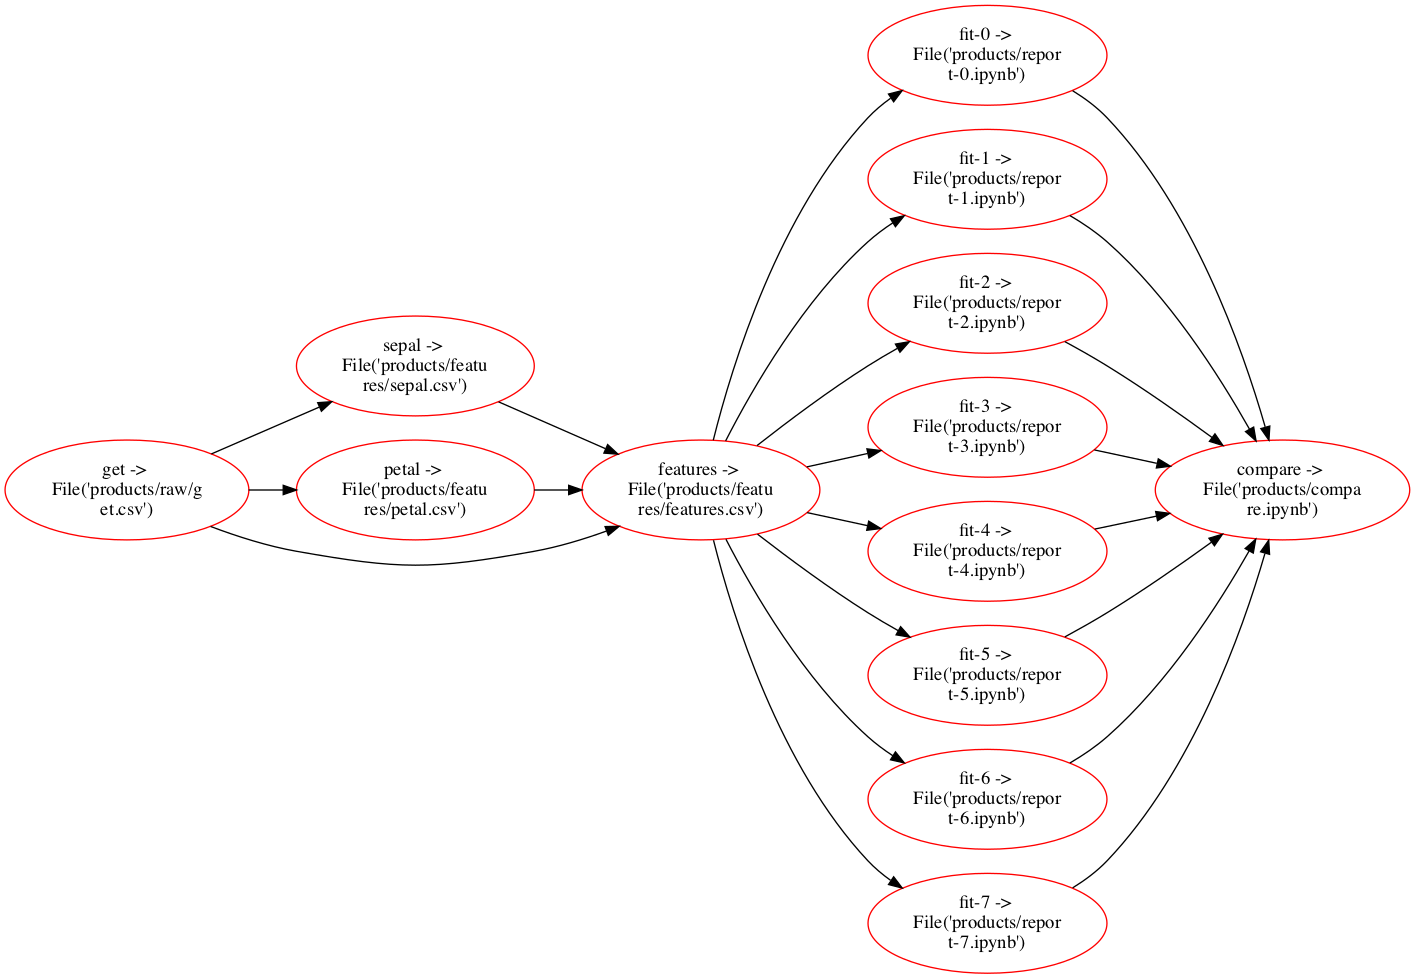

In [2]:
dag = DAGSpec('pipeline.yaml').to_dag()

# this is the same as doing "ploomber plot" from the command line
dag.plot()

The pipeline gets the iris dataset (`get` task), creates a few features (`sepal`, and `petal` tasks), and joins everything into a single file (`features` task). Then we see eight tasks in parallel (`fit-0` to `fit-7`); they all use the same script as a source but train different models; we log the models to MLflow here. Finally, we have a task (`compare`) that uses MLflow's API to query the runs and prints the best overall experiment.

Now that we have a high-level idea of what the pipeline is doing, let's look at the `pipeline.yaml`:

```yaml
# Content of pipeline.yaml
# uncomment to run in parallel
# executor: parallel

tasks:
  - source: tasks.raw.get
    product: products/raw/get.csv

  - source: tasks.features.sepal
    product: products/features/sepal.csv

  - source: tasks.features.petal
    product: products/features/petal.csv

  - source: tasks.features.features
    product: products/features/features.csv

  - source: scripts/fit.py
    name: fit-
    # we need to turn this off because parameters depend on the type of model
    static_analysis: false
    product: products/report.ipynb
    grid:
      - model: sklearn.ensemble.RandomForestClassifier
        n_estimators: [10, 20]
        criterion: [gini, entropy]
        params_names: [[n_estimators, criterion]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
      - model: sklearn.ensemble.AdaBoostClassifier
        n_estimators: [10, 20]
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report


  - source: scripts/compare.py
    product: products/compare.ipynb
    params:
      mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
```

The first four tasks are simple, they execute Python functions to prepare the data. The 5th and 6th entries are the interesting ones. Let's analyze the 5th entry first:

```yaml
# Content of pipeline.yaml

  - source: scripts/fit.py
    name: fit-
    # we need to turn this off because parameters depend on the type of model
    static_analysis: false
    product: products/report.ipynb
    grid:
      - model: sklearn.ensemble.RandomForestClassifier
        n_estimators: [10, 20]
        criterion: [gini, entropy]
        params_names: [[n_estimators, criterion]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
      - model: sklearn.ensemble.AdaBoostClassifier
        n_estimators: [10, 20]
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report

```

The task uses `scripts/fit.py` as its source and sets the name to `fit-` so that generated tasks have the same prefix. Then we set `static_analysis` to `false`, the static analysis feature checks that the parameters passed to the task match the ones declared by the script (in the `parameters` cell). Still, since we'll be passing different parameters depending on the model, we have to turn off this feature. Finally, we can see that we'll store the output in `products/report.ipynb`.

`grid` is where the magic happens. This feature allows us to pass a grid of parameters and generate many tasks from a single declaration. For example, the first element states we want to train a random forest and vary some hyperparameters (`n_estimator`, and `criterion`).

`params_names` is a list of parameters that we are going to vary across experiments; we use this list to pass the values to the model constructor (since depend on the model type), for example:

In [3]:
from sklearn.ensemble import RandomForestClassifier

# init parameters depend on model type
model = RandomForestClassifier(n_estimators=10, criterion='gini')

`track` controls whether to track experiments with MLflow or not; it's turned off by default because we may want to open `scripts/fit.py` and edit it interactively using Jupyter without tracking anything. `mlflow_tracking_uri` is the URI that we'll use for MLflow. Note that `track` and `mlflow_tracking_uri` are placeholders, and their values come from an `env.yaml` file, whose contents are shown next:

```yaml
# Content of env.yaml
track: false
mlflow_tracking_uri: 'file:{{root}}/mlruns'
```

We can see that `track` is set to `false`, and `mlflow_tracking_uri` to `file:{{root}}/mlruns`. Ploomber automatically resolves the `{{root}}` placeholder to the parent directory of our `pipeline.yaml` file, but we could have an explicit value instead (e.g., `file:/path/to/directory`).

Let's take a look at the portion of `scripts/fit.py` that uses `track` and `mlflow_tracking_uri`:

```python
# Content of scripts/fit.py
if track:
    print('tracking with mlflow...')
    mlflow.set_tracking_uri(mlflow_tracking_uri)

    @atexit.register
    def end_run():
        mlflow.end_run()
else:
    print('tracking skipped...')
    mlflow = Mock()

```

If `track` is `True`, we set the tracking URI and use the built-in `atexit` module to ensure that we call `mlflow.end_run` when our script finishes execution. If `track` is `False`, we mock `mlflow` (using a built-in module) so all our calls to `mlflow` don't do anything.


Now that we explained what each parameter is doing, let's go back to our task declaration:

```yaml
# Content of pipeline.yaml

  - source: scripts/fit.py
    name: fit-
    # we need to turn this off because parameters depend on the type of model
    static_analysis: false
    product: products/report.ipynb
    grid:
      - model: sklearn.ensemble.RandomForestClassifier
        n_estimators: [10, 20]
        criterion: [gini, entropy]
        params_names: [[n_estimators, criterion]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
      - model: sklearn.ensemble.AdaBoostClassifier
        n_estimators: [10, 20]
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report

```

The total number of tasks generated by grid depends on the number of parameters; for the first entry, we have:

1. `model` (1 element)
2. `n_estimators` (2)
3. `criterion` (2)
4. `params_names` (1) - see note below
5. `track` (1)
6. `mlflow_tracking_uri` (1)

This will generate a total of `1 * 2 * 2 * 1 * 1 * 1 = 4` tasks.

Note that `params_names` is a list with one element because by default, `grid` interprets lists as `"create one task per element on the list"`, but we don't want that. In this case, we want all tasks to receive the complete list, and we ensure this by passing a list with a single element.

The next entry on the grid is similar and generates another four tasks.

To see more clearly what parameters each task receives, let's use the `dag` object to print the parameters of the first two `fit-` tasks:

In [4]:
import black

fm = black.FileMode()

tasks_fit = [t for t in dag.values() if 'fit' in t.name]

for task in tasks_fit[:2]:
    if 'fit' in task.name:
        params = black.format_str(str(task.params), mode=fm)
        print(f'{task.name} params:\n{params}')

fit-0 params:
{
    "model": "sklearn.ensemble.RandomForestClassifier",
    "n_estimators": 10,
    "criterion": "gini",
    "params_names": ["n_estimators", "criterion"],
    "track": False,
    "mlflow_tracking_uri": "file:/Users/Edu/dev/projects-ploomber/templates/mlflow/mlruns",
    "upstream": Upstream({"features": File("products/features/features.csv")}),
    "product": File("products/report-0.ipynb"),
}

fit-1 params:
{
    "model": "sklearn.ensemble.RandomForestClassifier",
    "n_estimators": 10,
    "criterion": "entropy",
    "params_names": ["n_estimators", "criterion"],
    "track": False,
    "mlflow_tracking_uri": "file:/Users/Edu/dev/projects-ploomber/templates/mlflow/mlruns",
    "upstream": Upstream({"features": File("products/features/features.csv")}),
    "product": File("products/report-1.ipynb"),
}



You can see that most parameters are the same, except for `criterion` (the first one has `gini`, and the second one `entropy`).

## Running the pipeline

Every parameter declared in `env.yaml` can be switched from the command line; let's get the `--help` information to see how to do it:

In [5]:
%%bash
ploomber build --help

usage: ploomber [-h] [--log LOG] [--log-file LOG_FILE]
                [--entry-point ENTRY_POINT] [--force] [--skip-upstream]
                [--partially PARTIALLY] [--debug] [--env--track ENV__TRACK]
                [--env--mlflow_tracking_uri ENV__MLFLOW_TRACKING_URI]

Build pipeline

optional arguments:
  -h, --help            show this help message and exit
  --log LOG, -l LOG     Enables logging to stdout at the specified level
  --log-file LOG_FILE, -F LOG_FILE
                        Enables logging to the given file
  --entry-point ENTRY_POINT, -e ENTRY_POINT
                        Entry point, defaults to pipeline.yaml
  --force, -f           Force execution by ignoring status
  --skip-upstream, -su  Skip building upstream dependencies. Only applicable
                        when using --partially
  --partially PARTIALLY, -p PARTIALLY
                        Build a pipeline partially until certain task
  --debug, -d           Drop a debugger session if an exception happen

As you can see, we can use `--env--track` to switch the track flag. So let's run the pipeline and switch this value to ensure MLflow tracks our experiments:

In [6]:
%%bash
# note: this will take about a minute to run
ploomber build --env--track true

name      Ran?      Elapsed (s)    Percentage
--------  ------  -------------  ------------
get       True         0.009221    0.010966
sepal     True         0.005975    0.00710573
petal     True         0.00792     0.00941881
features  True         0.013479    0.0160298
fit-0     True        10.0891     11.9984
fit-1     True         9.50392    11.3025
fit-2     True         9.2422     10.9912
fit-3     True         9.83848    11.7003
fit-4     True        12.8643     15.2987
fit-5     True         9.26906    11.0232
fit-6     True         9.72535    11.5658
fit-7     True        10.2703     12.2139
compare   True         3.24783     3.86246


Building task 'compare': 100%|██████████| 13/13 [01:54<00:00,  8.81s/it]


That's it! We just trained eight models and logged them to MLflow! Here's how my MLflow looks like:

![list](images/list.png)

Note that `script/fit.py` organizes each model in a different MLflow experiment:

![experiments](images/experiments.png)

And logs all model parameters and metrics, but it also stores a confusion matrix and the model file:

![artifacts](images/artifacts.png)

But more importantly, it stores the executed notebook as an HTML file!

![report](images/report.png)

Storing the notebook helps debug: we can use `print` statements in our script to log any helpful information; furthermore, since this is an HTML file, it may contain other details such as printed data frames or charts. I'll explain how we achieve this in the next section.

## Storing executed notebooks in MLflow

Ploomber has a feature called "hooks", which allows running code when a task finishes execution. In our case, we're using it for converting the generated notebook to HTML and log it to MLflow:

```python
# Content of hooks.py
import mlflow
from nbconvert import HTMLExporter
from sklearn_evaluation import NotebookIntrospector


def store_report(product, params):
    if params['track']:
        nb = NotebookIntrospector(product)
        run_id = nb['mlflow-run-id'].strip()

        # https://nbconvert.readthedocs.io/en/latest/config_options.html#preprocessor-options
        exporter = HTMLExporter()
        # hide code cells
        exporter.exclude_input = True
        body, _ = exporter.from_filename(product)

        with mlflow.start_run(run_id):
            mlflow.log_text(body, 'nb.html')

```

We add `product` and `params` to the function signature to tell Ploomber that we want the `product` that the task generates and the task params. We use this to load the generated notebook and convert it to HTML. Then we retrieve the run id and log it to MLflow.

*Note: we're using sklearn_evaluation.NotebookIntrospector to retrieve mlflow's run id from the executed notebook, [click here](https://sklearn-evaluation.readthedocs.io/en/stable/user_guide/NotebookCollection.html) to learn more about how this works.*

To register the hook, we add the `on_finish` entry to the task declaration:

```yaml
# Content of pipeline.yaml
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report

```


## Visualizing results in MLflow (UI)

To review your experiments using MLflow's web application, click
`File -> New -> Terminal` on the JupyterLab menu bar and execute the following
command in the Terminal tab.

```
cd projects/mlflow/
mlflow ui
```

*If you're running this example locally:*

Upon initialization, go to [http://127.0.0.1:5000](http://127.0.0.1:5000) to open MLflow (`5000` is the default port, but it may change, check out the URL printed in the terminal)

*If you're running this example on Binder:*

The URL in your browser should look like this `https://{x}.mybinder.org/user/ploomber-{y}/lab/tree/projects/mlflow`. Copy the URL, open a new tab and delete everything after the `ploomber-y` portion (in our case, that would be `lab/tree/projects/mlflow`) and append `proxy/5000/` (note the trailing `/`), your URL should look like this: `https://{x}.mybinder.org/user/ploomber-{y}/proxy/5000/`.


## Visualizing results in MLflow (CLI)

If you're running this example locally, you may start MLflow with the following command:

```sh
mlflow ui
```

If you're using Binder, you can use MLflow's CLI to see the results. List experiments:

In [7]:
%%bash
mlflow experiments list

  Experiment Id  Name                    Artifact Location
---------------  ----------------------  -----------------------------------------------------------------
              0  Default                 file:///Users/Edu/dev/projects-ploomber/templates/mlflow/mlruns/0
              1  RandomForestClassifier  file:///Users/Edu/dev/projects-ploomber/templates/mlflow/mlruns/1
              2  AdaBoostClassifier      file:///Users/Edu/dev/projects-ploomber/templates/mlflow/mlruns/2


In [8]:
%%bash
mlflow runs list --experiment-id 1

Date                     Name    ID
-----------------------  ------  --------------------------------
2021-10-27 21:32:06 EDT          ba3734fb63024238ac09039e2b6a6e0e
2021-10-27 21:31:55 EDT          8a994f34a40c43699c8e9325ca191325
2021-10-27 21:31:46 EDT          ee1fde5d588f41b894372ea994ce3f63
2021-10-27 21:31:34 EDT          fb2ec4222e914f798c2343f73122f40c
2021-10-18 22:23:07 EDT          0bcb3ebfaced48ddb37e0ab3164ba9dd
2021-10-18 22:22:56 EDT          ce8e06b27a7641aea276284e5655641c
2021-10-18 22:22:46 EDT          189cce962ddb44b9b4fd5ef484401cf4
2021-10-18 22:22:37 EDT          7e31d3aac19f4867a1396b63ad5455bc


## Running experiments in parallel

To run tasks in parallel, we must include the following in our `pipeline.yaml` file:

```yaml
executor: parallel

# pipeline.yaml continues...
```

But if we want to run tasks serially, we can remove that line. For example, we may want to do this if each experiment needs too much memory and it's not possible to run them all at once.

## Selecting the best experiment

The final task in our pipeline generates a notebook that prints the best experiment overall. We want this task to execute after all our experiments are done, but we cannot list all of them because the exact number may change (e.g., suppose you add more parameters to the random forest grid). Ploomber allows us wildcards to solve this:

```python
# Content of scripts/compare.py
# + tags=["parameters"]
upstream = ['fit-*']
product = None
```

Our `scripts/compare.py` declares upstream dependencies with the wildcard `fit-*`, which translates to "execute all tasks that match the `fit-*` pattern before `scripts/compare.py`".

## Using functions instead of scripts/notebooks

Ploomber gives users the flexibility to use functions, scripts, or notebooks as tasks. If you prefer to use functions, you can use the same code and put it in a function. The advantage of using a script or notebook is that you can log all the output, just like we showed earlier.